In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image
import torch
from torch.autograd import Variable
!pip install hiddenlayer
import hiddenlayer as hl
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [2]:
#!unzip "/content/drive/MyDrive/Reto Empresarial/Copy of fashion-mnist.zip"

In [3]:

# Rutas de los archivos
train_files = glob('fashion-mnist/train/*/*.png')
valid_files = glob('fashion-mnist/valid/*/*.png')
test_files = glob('fashion-mnist/test/*/*.png')

print('La primera ruta es: ',train_files[0])

# Se vueleven aleatorios los archivos
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

#Se toma un porcentaje de los datos para disminuir el tiempo de entrnamiento
porcentaje = 0.1

train_files = train_files[:int(porcentaje*len(train_files))]
valid_files = valid_files[:int(porcentaje*len(valid_files))]
test_files = test_files[:int(porcentaje*len(test_files))]



print('Las longitudes son: train {}, valid {}, test {}'.format(len(train_files), len(valid_files), len(test_files)))

# Transforma los datos para adaptarlos a la entrada de ResNet 224x224 px
data_transform = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.Grayscale(3),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])

# Se cargan las imagenes en las listas
# Datos de entrenamiento
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
    Y_train.append(int(train_file.split('/')[2]))
    X_train.append(np.array(data_transform(Image.open(train_file))))

# Datos de validación 
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
    Y_valid.append(int(valid_file.split('/')[2]))
    X_valid.append(np.array(data_transform(Image.open(valid_file))))

# Datos de prueba
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
    Y_test.append(int(test_file.split('/')[2]))
    X_test.append(np.array(data_transform(Image.open(test_file))))

print('Verificamos las longitudes: Tr {}, V {}, Te {}'.format(len(X_train), len(X_valid), len(X_test)))

def tensor (X,Y):
    X = Variable(torch.from_numpy(np.array(X))).float()
    Y = Variable(torch.from_numpy(np.array(Y))).long()
    return X,Y

X_train_p, Y_train_p = tensor(X_train, Y_train)
X_valid_p, Y_valid_p = tensor(X_valid, Y_valid)
X_test_p, Y_test_p = tensor(X_test, Y_test)

batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train_p, Y_train_p)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)


La primera ruta es:  fashion-mnist/train/6/47123.png
Las longitudes son: train 5500, valid 1000, test 500
Verificamos las longitudes: Tr 5500, V 1000, Te 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


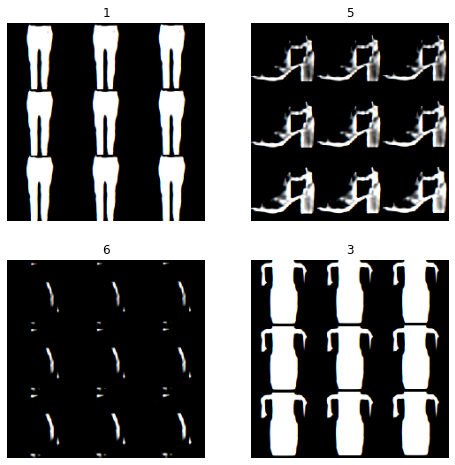

In [4]:
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15].reshape(224,224,3))
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [5]:
def CM(Y_true, Y_pred, classes):
    fig = plt.figure(figsize=(10, 10))
    cm = confusion_matrix(Y_true.detach().cpu().numpy(), Y_pred.detach().cpu().numpy())
    lclasses = np.arange(0,classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmap=plt.cm.Blues
    ax = fig.add_subplot(1,1,1)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
    ax.set_xlabel("Predicted",size=20)
    ax.set_ylabel("True",size=20)
    ax.set_ylim(classes-0.5, -0.5)

    plt.setp(ax.get_xticklabels(), size=12)
    plt.setp(ax.get_yticklabels(), size=12)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

    plt.show()

def entrena(X_train,Y_train,X_test,Y_test,model,optimizer,criterion,train_dl):
    n_epochs = 5

    history = hl.History()
    canvas = hl.Canvas()

    iter = 0

    for epoch in range(n_epochs):
      for batch_idx, (X_train_batch, Y_train_batch) in enumerate(train_dl):
        # Pasamos os datos a 'cuda'
        
        X_train_batch = X_train_batch
        Y_train_batch = Y_train_batch

        # Realiza una predicción
        Y_pred = model(X_train_batch)

        # Calcula el loss
        loss = criterion(Y_pred, Y_train_batch)

        Y_pred = torch.argmax(Y_pred, 1)

        f1 = f1_score(Y_train_batch,Y_pred, average='macro')

        # Calcula el accuracy
        acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if iter%10 == 0:
            #-- Visualizamos la evolución de los score loss y accuracy
            history.log((epoch+1, iter), loss=loss, accuracy=acc,f1=f1)
            with canvas:
              canvas.draw_plot(history["loss"])
              canvas.draw_plot(history["accuracy"])
              canvas.draw_plot(history["f1"])

        iter += 1
        del X_train_batch, Y_train_batch, Y_pred

Depués de una busqueda en internet, encontré que el modelo preentrenado que mejor funciona para este tipo de procesos de clasificación es Alexnet, es por esto que se va a transferir el conocimiento de este modelo. 

In [6]:
model = torch.hub.load('pytorch/vision', 'alexnet', pretrained=True)
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
for p in model.parameters():
    p.requires_grad = False

out_dim = 10

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),  
    torch.nn.Linear(9216, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(4096, out_dim)
)

model.load_state_dict(model.state_dict())

#model = model.cuda()

model.train()

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

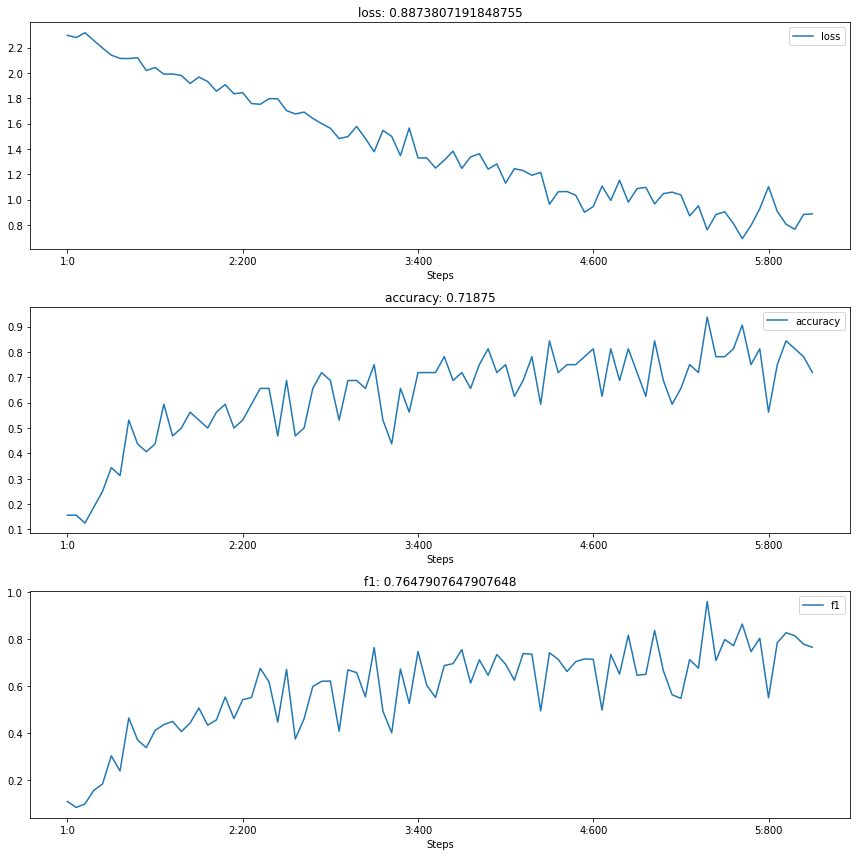

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()

print('*')
print('*')
print('Entrenando el modelo')
print('*')

entrena(X_train_p,Y_train_p,X_test_p, Y_test_p,model,optimizer,criterion,train_dl)


Como se puede ver en la gráficas, y en especial comparando con lo que se hizo en los anteriores ejercicios, nos podemos dar cuenta que al transferir el conocimiento del modelo, tiene un valor de accuracy y de f1 muchísimo mejor. Esto se va a ver demostrado más adelante en la matriz de confusión. 

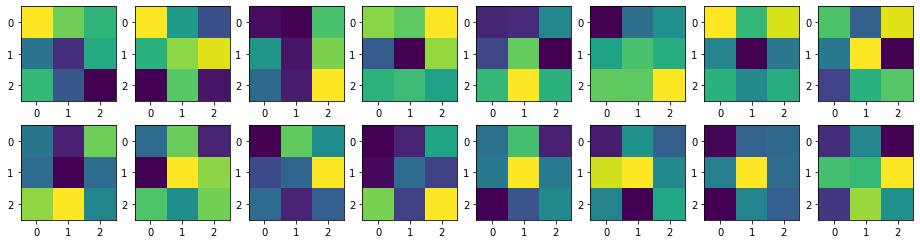

In [9]:
kernels = list(model.children())[0][10].weight.detach()

fig = plt.figure(figsize=(16,4))
k = 0
for i in range(16):
    plt.subplot(2,8,k+1)
    plt.imshow(kernels[0][i].squeeze())
    k += 1
plt.show()

In [10]:
model.eval()

Y_pred = model(X_test_p)
loss = criterion(Y_pred,Y_test_p)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test_p, Y_pred, average='macro')

acc = sum(Y_test_p == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.70, F1:0.74, Acc:0.77


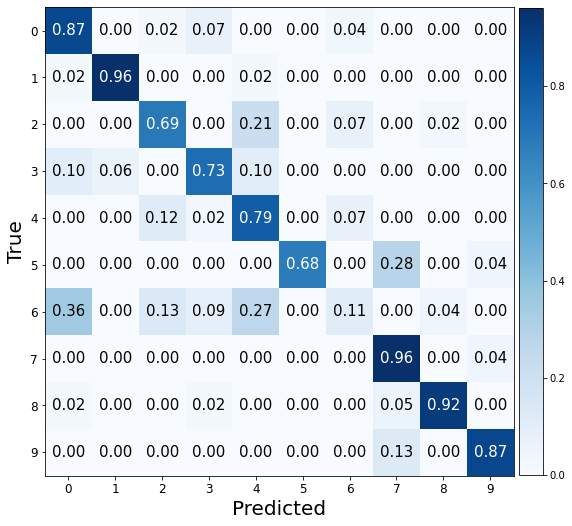

In [11]:
CM(Y_test_p, Y_pred, 10)

Como se puede ver en la matriz de confusión tenemoos un muy buen modelo que puede categorizar entre los 10 tipos de prendas de ropa. Sin embargo, en los pequeños errores que hay se deben probablemente a que los datos que se tomaron hay pocas camisas y se pueden facilmente confundir con sacos camisetas entre otras prendas de vestir que inclusive nosotros como humanos confundimos (yo no las diferencio :) )